

The aim of this notebook is to derive integrated flux, linewidhts and HI-mass of an HI galaxy.  This is done by using mbspect from miriad.  The main confusion here is on applying the beam correction.  What I did is the following:

* Fit lower order polynomial.
* Applying 3 hanning smoothing.
* Identify and mask the profile.
* Specify spectral range.

After I've derived the HI parameters I then compare my results with literature (Ramatsoku et al. 2016)



In [1]:


from mirpy import miriad
from astropy.io import fits
from numpy import log,pi
dir = '/Users/themba/Documents/MSc/Thesis/Catalogue/ppmos1/'
from astropy import units as u
import matplotlib.pyplot as plt
import aplpy
#import wand.image as Image
from IPython.display import Image


### DATASET

In [47]:

test = dir+'test.mir'             # data file
hdr = miriad.prthd(In=test)
hdr.split('\n')


['prthd: Revision 1.10, 2012/03/02 06:13:02 UTC',
 '',
 '****************************************************************',
 'Filename: /Users/themba/Documents/MSc/Thesis/Catalogue/ppmos1/test.mir',
 'Map flux units: JY/BEAM',
 'Beam Size:  23.37 by  16.61 arcsec.',
 'Position angle:    0.1 degrees.',
 'This image has 3 axes.',
 '----------------------------------------------------------------',
 'Type     Pixels  Coord Value  at  Pixel     Coord Incr   Units',
 'RA---SIN     82   04:58:10.069    41.00   -6.000000E+00  arcsec',
 'DEC--SIN     82  +46:02:22.876    41.00    6.000000E+00  arcsec',
 'VELO-HEL    200   7.090628E+03   100.00    8.244576E+00  km/s',
 '----------------------------------------------------------------',
 'Average time of observation: 00JAN01:12:00:00.0',
 'Equinox:                     J2000.0',
 'Rest frequency:              1.420406 GHz',
 'History item is present']

### Linewidths & integrated flux

We derive the HI parameters by making use of MBSPECT from miriad.


In [41]:

Mask = (7040,7300)                # profile velocity window
xran = (Mask[0]-600,Mask[1]+600)  # Spectral range
m=miriad.mbspect(In=test,hann='3',order=1,options=("measure"),mask=Mask,profile=(Mask[0],Mask[1]) #fit 1st order-polynomial
               ,xrange=xran,device=(dir+"Test.ps/cps"),comment="Test")
n = m.split('\n')
n


['#FR   Clipped rms:    0.0003 Jy/b',
 '#FN   ( 126 out of  173 channels)',
 '#     SPECTRAL FITTING',
 '#MC   xaxis: VELO',
 '#MX   Maximum:      0.002 Jy/b   at   7166.017 km/s',
 '#MN   Minimum:     -0.000 Jy/b   at   7047.890 km/s',
 '#NP   Number of spectral points:    30',
 '#SN1  Peak S/N ratio =       8.23',
 '#CL   Clipping inside range (   -0.000,    0.000) Jy/b',
 '      Moment:         0               1               2',
 '#MM                  0.215        7156.898          36.826',
 '#SN2  Mean S/N ratio =       3.36',
 '      Robust moments: 0               1               2',
 '#MR                  0.203        7154.323          27.356',
 '      units:        Jy/b km/s       km/s            km/s',
 '',
 '      Width maximiser:',
 '                             50%            20%',
 '#MXC  Line centre:        7155.282        7158.096',
 '#MXW  Line width:          106.883         131.613',
 '      units:                km/s            km/s',
 '',
 '      Width minimiser:',

In [160]:

peak_SN = float(n[7].split()[-1])                         # peak flux
F_int   = float(n[13].split()[1])*u.Jy/u.beam*u.km/u.s    # integrated flux from miriad
v_sys   = float(n[18].split()[-2])*u.km/u.s               # Assume V_sys to be the line centre associated with W_50
w_20    = float(n[19].split()[-1])*u.km/u.s               # 20% linewidht
w_50    = float(n[19].split()[-2])*u.km/u.s               # 20% linewidht


### Deriving HI mass


To achieve this we use the equations below.  The first equation is used for beam correction and the second one for calculating HI mass.

\begin{eqnarray}
\mathrm{beam_{-}area} &=& \frac{\pi \theta_{\mathrm{maj}} \theta_{\mathrm{min}}}{4 \log (2)} \hspace{9cm} (1)\\\\
\mathrm{M}_{\odot}&=& 2.36 \times 10 ^5 \left( {F_{\mathrm{int}}}\times D^2 \right)\hspace{6.8cm} (2)
\end{eqnarray}

In [161]:

beam_area = (pi * (23.37 * 16.61)/6.**2)/(4.0 * log(2.0))*u.beam # Both beam major & minor axis are in the header
H0        = 70.*u.km/u.s /u.Mpc                                  # Assumed cosmological constant
def HI_MASS(v,f):                                                # Function for deriving HI mass "Eq. 2"
    flux= f *beam_area.value  #beam corrected flux [Jy km/s]
    d   = v/H0.value                                             #Distance in Mpc
    hi_mass = 2.36e+5*flux* d**2
    HI_mass = log(hi_mass) / log(10.0)
    return (int(round(d)),round(flux,3),round(HI_mass,2))       #returns: distance,beam_correctd flux
                                                                #and log(HI mass)
    

In [234]:

D,f_int,HI_mass=HI_MASS(v_sys.value,F_int.value)
D = D*u.Mpc
f_int =f_int*u.Jy*u.km/u.s 

print "SOURCE              RA             Dec      V_sys      W_20         W_50         F_int         D     HI-Mass"
print ("Themba     O4 58 09.49     46 02 48.88       "+str(int(v_sys.value))+"       "+str(int(round(w_20.value)))+
       "          "+str(int(w_50.value))+"          "+str(f_int.value)+"       "+str(int(D.value))+"        "+str(HI_mass))
print ("Mpati      04 58 10.84     46 02 29.40    7137 ±01   219 ±03      204 ±05    1.36 ±0.07        102        9.5")



SOURCE              RA             Dec      V_sys      W_20         W_50         F_int         D     HI-Mass
Themba     O4 58 09.49     46 02 48.88       7155       132          106          2.48       102        9.79
Mpati      04 58 10.84     46 02 29.4    7137 ±01   219 ±03      204 ±05    1.36 ±0.07        102        9.5


#### The printout table above shows parameters of the same source that were derived by two different individuals.   The first row is derived by me and the second is from Ramatsoku et al. 2016.   Themba's parameters are derived from a data cube with velocity resolution of 8.24 km/s, while Mpati's are from a smoothed data cube version (16.5 km/s velocity resolution).


### Moment maps

Here I show the moment maps and the global profile of the source in question.  Note all this plots shown below, were derived in miriad.

In [158]:
mom0=miriad.moment(In=test,mom=0,clip=3*0.4e-3,out=dir+'mom0')             # Create moment zero map
mom1=miriad.moment(In=test,mom=1,clip=4.5*0.4e-3,out=dir+'mom1')           # Create moment one map
miriad.fits(In=dir+'mom0',op='xyout',out=dir+'test.fits',overwrite=True)   # Write mom0 into a fits file
miriad.fits(In=dir+'mom1',op='xyout',out=dir+'mom1.fits',overwrite=True)   # Write mom1 into a fits file


'fits: Revision 1.32, 2014/09/15 04:39:01 UTC'

### Use Aplpy to make a plot of the mom0 map.

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -3.803e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.690e-01 [aplpy.core]


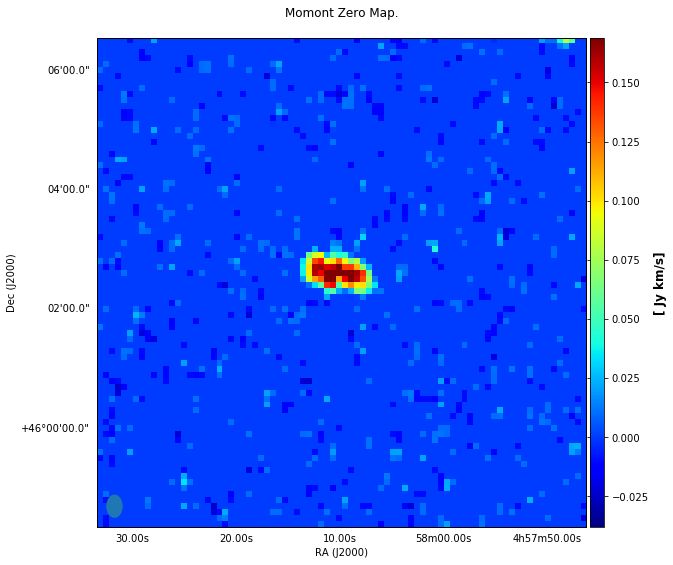

In [266]:

#Use Aplpy to make a plot of the mom0 map.
fig = aplpy.FITSFigure(dir+'test.fits')
fig.show_colorscale(stretch='linear')
fig.show_colorbar()
fig.add_label(0.5, 1.05, 'Momont Zero Map.', relative=True, size='large', layer='title')
fig.colorbar.set_axis_label_text('[ Jy km/s]' )
fig.colorbar.set_axis_label_font(size=12, weight='bold')
fig.add_beam()
fig.savefig(dir+"mom0.png")
Image(dir+"mom0.png", width=600, height=300)


### Use Aplpy to make a plot of the mom1 map.


INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to  7.012e+03 [aplpy.core]
INFO: Auto-setting vmax to  7.226e+03 [aplpy.core]


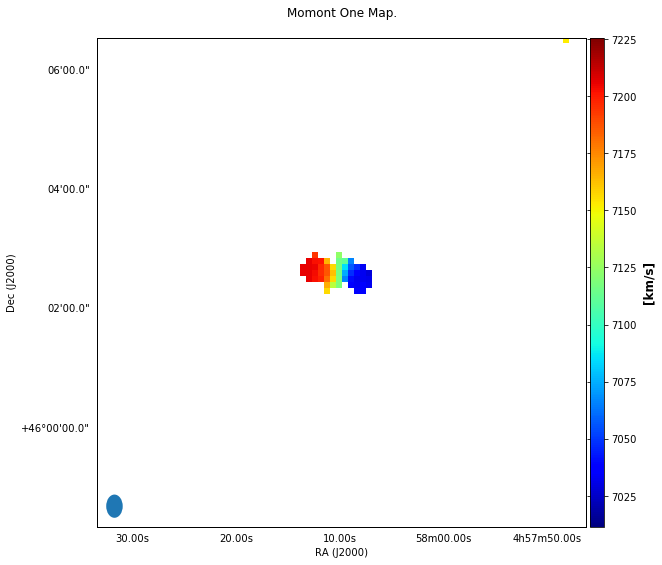

In [262]:

fig1 = aplpy.FITSFigure(dir+'mom1.fits') 
fig1.show_colorscale(stretch='linear')
fig1.show_colorbar()
fig1.add_label(0.5, 1.05, 'Momont One Map.', relative=True, size='large', layer='title')
fig1.colorbar.set_axis_label_text('[km/s]' )
fig1.colorbar.set_axis_label_font(size=12, weight='bold')
fig1.add_beam()
fig1.savefig(dir+"mom1.png")
Image(dir+"mom1.png", width=600, height=300)


### Global profile from Miriad.

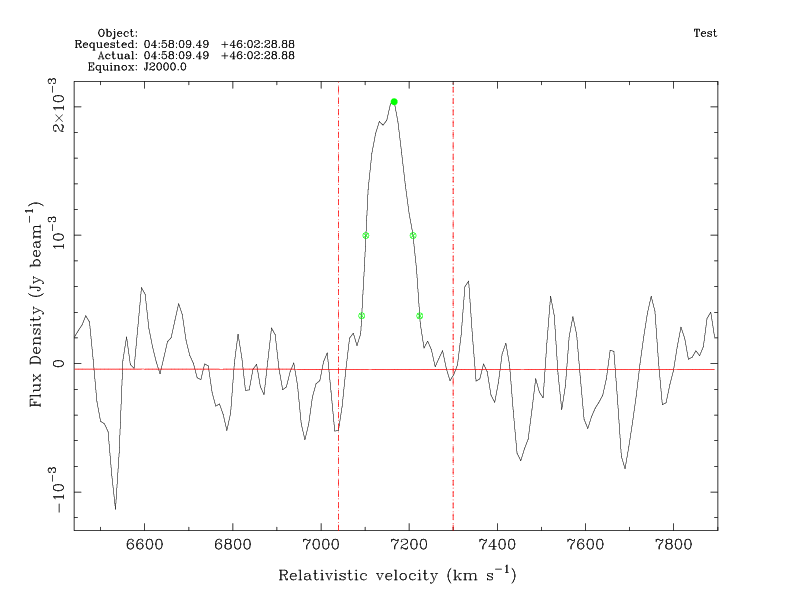

In [264]:

Image(dir+"Test.png", width=600, height=300)
